In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import math
from statistics import mean as stat_mean
from importlib import reload

In [2]:
# Load Data
data = pd.read_csv('../fulldata.csv', index_col = 'Date')
data.shape

(2492, 50)

<IPython.core.display.Javascript object>


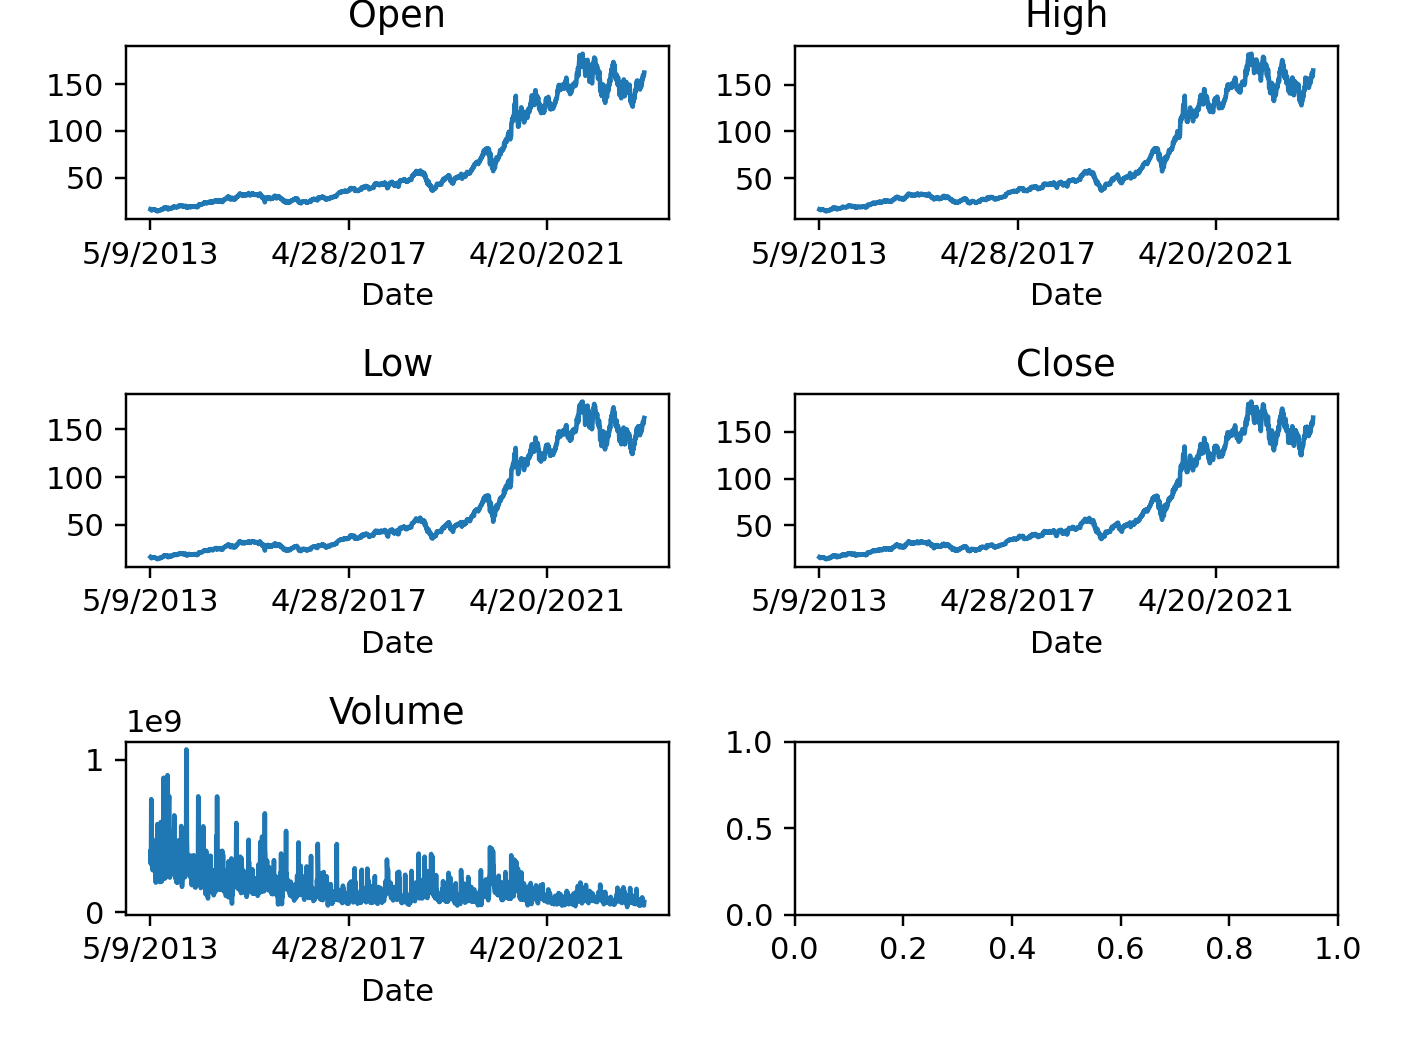

Text(0.5, 1.0, 'Volume')

In [3]:
# Visualize Dataset
%matplotlib notebook

# Create Subplot Figure for all Columns
subplotFig, subplotAx = plt.subplots(3,2, num='Basic Indicator History ($AAPL)')

# Plot All Data Columns (Open,High,Low,Close,& Volume)
data['open_aapl'].plot(ax=subplotAx[0,0])
data['high_aapl'].plot(ax=subplotAx[0,1])
data['low_aapl'].plot(ax=subplotAx[1,0])
data['close_aapl'].plot(ax=subplotAx[1,1])
data['volume_aapl'].plot(ax=subplotAx[2,0])

# Adjust Figure Layout
plt.tight_layout(pad = 1.5)

# Add Subplot Titles
subplotAx[0,0].set_title("Open")
subplotAx[0,1].set_title("High")
subplotAx[1,0].set_title("Low")
subplotAx[1,1].set_title("Close")
subplotAx[2,0].set_title("Volume")

In [4]:
# Read over ARIMA predictions
%store -r full_arima_predictions

# Increment Indices
arima_predictions_list = full_arima_predictions.tolist()
arima_predictions_list.append(arima_predictions_list.pop(0))

# Append ARIMA predictions to dataframe
data['arima'] = arima_predictions_list

# Append close to dataframe
data['y'] = data['close_aapl']

In [5]:
#Data preview
data

,open_aapl,high_aapl,low_aapl,close_aapl,volume_aapl,open_googl,high_googl,low_googl,close_googl,volume_googl,...,momentum,rsi_5,rsi_15,rsi_ratio,tr,atr,roc,vader_polarity,arima,y
Date,,,,,,,,,,,,,,,,,,,,,
5/9/2013,16.421786,16.535714,16.270714,16.313214,398749904,21.792098,22.012812,21.726785,21.808114,87945080,...,15.313214,66.171526,64.804242,1.021099,0.295000,0.419158,0.165081,0.131248,16.313212,16.313214
5/10/2013,16.356071,16.418214,16.088572,16.177500,334849928,21.903956,22.034833,21.825130,22.027075,75955060,...,15.177500,57.572386,61.822287,0.931256,0.329643,0.412934,0.159885,0.146785,16.191360,16.177500
5/13/2013,16.125357,16.353572,16.125000,16.240714,317109240,21.993543,22.083127,21.855684,21.959510,57893080,...,15.240714,60.556778,62.679325,0.966136,0.228572,0.404487,0.140643,0.063889,16.231099,16.240714
5/14/2013,16.208928,16.257143,15.791071,15.852143,447115760,21.958759,22.238780,21.949751,22.198992,63190600,...,14.852143,39.310535,54.606048,0.719893,0.466071,0.379742,0.092901,0.049072,15.893159,15.852143
5/15/2013,15.684286,15.750000,15.084286,15.316071,741612360,22.409198,22.931701,22.372159,22.919439,159658020,...,14.316071,24.492002,45.872465,0.533915,0.767857,0.412962,0.057682,0.011088,15.359893,15.316071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3/27/2023,159.940000,160.770000,157.870000,158.280000,52390266,104.615000,104.760000,101.927300,102.460000,31120864,...,157.280000,58.221301,60.577495,0.961104,2.900000,3.498250,0.028928,0.154446,158.428987,158.280000
3/28/2023,157.970000,158.490000,155.980000,157.650000,45992152,102.440000,102.450000,99.740000,101.030000,32057865,...,156.650000,53.185052,59.113390,0.899712,2.510000,3.543964,0.039908,0.171291,157.627915,157.650000
3/29/2023,159.370000,161.050000,159.350000,160.770000,51305691,102.280000,102.490000,100.650000,101.390000,28779572,...,159.770000,69.511345,63.760854,1.090188,3.400000,3.478964,0.051678,0.149073,160.714492,160.770000


In [6]:
# Data subset for tuning
new_data = data

In [7]:
# Convert data to numpy array
dataset = new_data.values

# Get training set size 80:10:10 split
training_data_len = math.ceil(len(dataset) * 0.8)
testing_data_len = math.ceil((len(dataset) - training_data_len)*0.5)
val_data_len = len(dataset) - training_data_len - testing_data_len
print('Training data length: ' + str(training_data_len))
print('Testing data length: ' + str(testing_data_len))
print('Validation data length: ' + str(val_data_len))

Training data length: 1994
Testing data length: 249
Validation data length: 249


In [8]:
# Scaler for data
scaler = MinMaxScaler(feature_range=(0,1))

In [9]:
# Create training dataset
train_data = dataset[0:training_data_len,:]

# Split to x_train and y_train
x_train = train_data[:,:51]
y_train = train_data[:,51]

# Create scaled test dataset
test_and_val_data = dataset[training_data_len:,:]

# Split to x_val and y_val
x_val = test_and_val_data[0:testing_data_len,:51]
y_val = test_and_val_data[0:testing_data_len,51]

# Split to x_test and y_test
x_test = test_and_val_data[testing_data_len:,:51]
y_test = test_and_val_data[testing_data_len:,51]

# Show shapes of sets
print('x_train shape: ' + str(x_train.shape))
print('y_train shape: ' + str(y_train.shape))
print()
print('x_val shape: ' + str(x_val.shape))
print('y_val shape: ' + str(y_val.shape))
print()
print('x_test shape: ' + str(x_test.shape))
print('y_test shape: ' + str(y_test.shape))

x_train shape: (1994, 51)
y_train shape: (1994,)

x_val shape: (249, 51)
y_val shape: (249,)

x_test shape: (249, 51)
y_test shape: (249,)


In [10]:
# Splits preview
print(y_train)
print(y_val)
print(y_test)

[ 16.31321425  16.1775      16.24071425 ... 127.9        130.36
 132.995     ]
[131.24 134.43 132.03 134.5  134.16 134.84 133.11 133.5  131.94 134.32
 134.72 134.39 133.58 133.48 131.46 132.54 127.85 128.1  129.74 130.21
 126.85 125.91 122.77 124.97 127.45 126.27 124.85 124.69 127.31 125.43
 127.1  126.9  126.85 125.28 124.61 124.28 125.06 123.54 125.89 125.9
 126.74 127.13 126.11 127.35 130.48 129.64 130.15 131.79 130.46 132.3
 133.98 133.7  133.41 133.11 134.78 136.33 136.96 137.27 139.96 142.02
 144.57 143.24 145.11 144.5  145.64 149.15 148.48 146.39 142.45 146.15
 145.4  146.8  148.56 148.99 146.77 144.98 145.64 145.86 145.52 147.36
 146.95 147.06 146.14 146.09 145.6  145.86 148.89 149.1  151.12 150.19
 146.36 146.7  148.19 149.71 149.62 148.36 147.54 148.6  153.12 151.83
 152.51 153.65 154.3  156.69 155.11 154.07 148.97 149.55 148.12 149.03
 148.79 146.06 142.94 143.43 145.85 146.83 146.92 145.37 141.91 142.83
 141.5  142.65 139.14 141.11 142.   143.29 142.9  142.81 141.51 140.91


In [11]:
# Convert sets to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

x_val = np.array(x_val)
y_val = np.array(y_val)

x_test = np.array(x_test)
y_test = np.array(y_test)

# Scale data
x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train.reshape(-1,1))

x_val = scaler.fit_transform(x_val)
y_val = scaler.fit_transform(y_val.reshape(-1,1))

x_test = scaler.fit_transform(x_test)
y_test = scaler.fit_transform(y_test.reshape(-1,1))

x_train

array([[0.01885966, 0.01712881, 0.01868894, ..., 0.78375968, 0.4121214 ,
        0.01733483],
       [0.01835269, 0.01623046, 0.01726017, ..., 0.77392832, 0.4330199 ,
        0.01639152],
       [0.01657281, 0.01573623, 0.01754592, ..., 0.73751712, 0.32151841,
        0.01669916],
       ...,
       [0.86290998, 0.86872551, 0.87268769, ..., 0.50650193, 0.50449132,
        0.87993629],
       [0.88697981, 0.88761008, 0.89920129, ..., 0.55632543, 0.40436208,
        0.8986756 ],
       [0.8935373 , 0.90787084, 0.90665333, ..., 0.66708059, 0.60343157,
        0.91915718]])

In [12]:
%store -r compressed_x_train
%store -r compressed_x_test

# Merge Compressed Feature Sets
compressed_x_val, compressed_x_test = np.split(compressed_x_test,2)

train_x = np.hstack((x_train, compressed_x_train))
train_y = y_train
val_x = np.hstack((x_val, compressed_x_val))
val_y = y_val
test_x = np.hstack((x_test, compressed_x_test))
test_y = y_test

# Code below modified from: https://github.com/ChickenBenny/Stock-prediction-with-GAN-and-WGAN/blob/main/wgan-gp_demo.ipynb

In [13]:
x_val

array([[0.15739028, 0.14082333, 0.14735361, ..., 0.70360579, 0.18311596,
        0.14241617],
       [0.15604506, 0.17186964, 0.17021277, ..., 0.6896395 , 0.39939772,
        0.18693638],
       [0.19808307, 0.17770154, 0.16537718, ..., 0.65043884, 0.4304644 ,
        0.15834533],
       ...,
       [0.91945519, 0.91578045, 0.91700369, ..., 0.72884236, 0.59945703,
        0.88001996],
       [0.85538927, 0.86174957, 0.87374714, ..., 0.81045387, 0.50827557,
        0.87594365],
       [0.86446948, 0.92367067, 0.91770705, ..., 1.        , 0.62067409,
        0.94721768]])

In [14]:
x_test

array([[1.        , 1.        , 1.        , ..., 0.88262266, 0.68172616,
        1.        ],
       [0.90017479, 0.90757966, 0.91471788, ..., 0.72383737, 0.50763859,
        0.97996377],
       [0.8768693 , 0.9022363 , 0.90914519, ..., 0.70866721, 0.45771848,
        0.98330401],
       ...,
       [0.64789279, 0.65861864, 0.70016917, ..., 0.64754028, 0.49457731,
        0.91739518],
       [0.68984269, 0.68672076, 0.73840183, ..., 0.72829805, 0.1365519 ,
        0.92629495],
       [0.70751602, 0.73679003, 0.75111951, ..., 0.82673479, 0.1365519 ,
        0.        ]])

In [15]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 7)
val_x_slide, val_y_slide, val_y_gan = sliding_window(val_x, val_y, 7)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 7)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'val_x: {val_x_slide.shape} val_y: {val_y_slide.shape} val_y_gan: {val_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([1987, 7, 76]) train_y: torch.Size([1987, 1]) train_y_gan: torch.Size([1987, 8, 1])
val_x: torch.Size([242, 7, 76]) val_y: torch.Size([242, 1]) val_y_gan: torch.Size([242, 8, 1])
test_x: torch.Size([242, 7, 76]) test_y: torch.Size([242, 1]) test_y_gan: torch.Size([242, 8, 1])


In [16]:
# Build Generator: Long Short Term Memory Network
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        
        #Build LSTM
        self.LSTM = nn.LSTM(input_size=input_size, hidden_size=512, num_layers=1, batch_first = True)
        self.output_layer = nn.Linear(512, 1, bias=False)
        

    def forward(self, x):
        # initialize hidden state
        h0 = torch.zeros(1, x.size(0), 512).requires_grad_()
        
        # initialize cell state
        c0 = torch.zeros(1, x.size(0), 512).requires_grad_()
        
        # Data Path through NN
        LSTM_out, (LSTM_hn, LSTM_cn) = self.LSTM(x, (h0.detach(), c0.detach()))
        output = self.output_layer(LSTM_out[:, -1, :])
        return output
        

# Build Discriminator: Convolutional Neural Network Version 3.2
class Discriminator(nn.Module):       
    def __init__(self):
        super().__init__()
        
        # 1-Dimensional Convolutional Layers with LeakyReLU and Batch Normalization
        self.conv_layer0 = nn.Conv1d(8, 32, kernel_size=5, stride=1, padding='same')
        self.conv_layer1 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding='same')
        self.leakyrelu_layer2 = nn.LeakyReLU(0.01)
        self.conv_layer3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding='same')
        self.leakyrelu_layer4 = nn.LeakyReLU(0.01)
        self.conv_layer6 = nn.Conv1d(128, 256, kernel_size=5, stride=1, padding='same')
        self.leakyrelu_layer7 = nn.LeakyReLU(0.01)
        
        # Fully Connected Layers
        self.dense_layer9 = nn.Linear(256, 256, bias=False)
        self.leakyrelu_layer11 = nn.LeakyReLU(0.01)
        self.dense_layer12 = nn.Linear(256, 256, bias=False)
        self.activation_layer13 = nn.ReLU()
        self.dense_layer14 = nn.Linear(256, 1)
        

    def forward(self, x):
        conv_layer0 = self.conv_layer0(x)
        conv_layer1 = self.conv_layer1(conv_layer0)
        leakyrelu_layer2 = self.leakyrelu_layer2(conv_layer1)
        conv_layer3 = self.conv_layer3(leakyrelu_layer2)
        leakyrelu_layer4 = self.leakyrelu_layer4(conv_layer3)
        conv_layer6 = self.conv_layer6(leakyrelu_layer4)
        leakyrelu_layer7 = self.leakyrelu_layer7(conv_layer6)
        reshape =  leakyrelu_layer7.reshape(leakyrelu_layer7.shape[0], leakyrelu_layer7.shape[1])
        dense_layer9 = self.dense_layer9(reshape)
        leakyrelu_layer11 = self.leakyrelu_layer11(dense_layer9)
        dense_layer12 = self.dense_layer12(leakyrelu_layer11)
        activation_layer13 = self.activation_layer13(dense_layer12)
        dense_layer14 = self.dense_layer14(activation_layer13)
        return dense_layer14

In [17]:
# Gradient Penalty Implementation
# Modified From: https://github.com/Zeleni9/pytorch-wgan/blob/master/models/wgan_gradient_penalty.py
def calculate_gradient_penalty(critic, real_data, fake_data):
    eta = torch.FloatTensor(fake_data.size(0),1,1).uniform_(0,1)
    eta = eta.expand(fake_data.size(0), real_data.size(1), real_data.size(2))

    # interpolate
    interpolated = eta * real_data + ((1 - eta) * fake_data)

    # define it to calculate gradient
    interpolated = Variable(interpolated, requires_grad=True)

    # calculate probability of interpolated examples
    prob_interpolated = critic(interpolated)

    # calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(
                               prob_interpolated.size()),
                           create_graph=True, retain_graph=True)[0]

    grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * 10
    return grad_penalty

In [18]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

from sklearn.model_selection import ParameterGrid

param_grid = {'epochs':[150],
              'learning_rate': [0.00005],
              'batch_size' : [64],
              'critic_iterations' : [5]}

grid = ParameterGrid(param_grid)

full_params_list = list()
iteration_count = 0

for params in grid:
    iteration_count+=1
    print(f'---------- Starting training with new params [{iteration_count}/{len(grid)}] ----------')
    print(params)
    
    # Hyperparameters set by grid search
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']
    num_epochs = params['epochs']
    critic_iterations = params['critic_iterations']
    
    # Data Loader    
    trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

    # Build Models
    modelG = Generator(76).to(device)
    modelD = Discriminator().to(device)

    # Build Optimizers
    optimizerG = torch.optim.RMSprop(modelG.parameters(), lr=learning_rate, alpha = 0.9)
    optimizerD = torch.optim.RMSprop(modelD.parameters(), lr=learning_rate, alpha = 0.9)

    # History Storage
    histG = np.zeros(num_epochs)
    histD = np.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        loss_G = []
        loss_D = []
        for (x, y) in trainDataloader:
            x = x.to(device)
            y = y.to(device)

            lossD_arr = []
            costG = 0

            # Generate Fake Data
            fake_data = modelG(x)
            fake_data = torch.cat([fake_data.reshape(-1, 1, 1), y[:, :7, :]], axis = 1)

            for i in range(critic_iterations):
                # Train Discriminator
                critic_loss_real = 0
                critic_loss_fake = 0
                critic_wasserstein = 0


                    # Train on real closing prices
                real_data = y
                critic_loss_real = modelD(real_data)
                critic_loss_real = torch.mean(critic_loss_real)

                    # Train on fake closing prices      
                critic_loss_fake = modelD(fake_data)
                critic_loss_fake = torch.mean(critic_loss_fake)


                    # Calculate Gradient Penalty
                gradient_penalty = calculate_gradient_penalty(modelD, real_data, fake_data)

                    # Compute Loss
                lossD = critic_loss_fake - critic_loss_real + gradient_penalty

                    # Zero Gradients
                modelD.zero_grad()

                    # Back Propogation
                lossD.backward(retain_graph = True)    
                lossD_arr.append(lossD)
                critic_wasserstein = -(critic_loss_real - critic_loss_fake)

                # Optimizer step
                optimizerD.step()

            # Train Generator

                # Compute Loss
            lossG = modelD(fake_data)
            lossG = -torch.mean(lossG)
            modelG.zero_grad()
            lossG.backward()
            optimizerG.step()

            # Append Losses
            loss_D.append((torch.mean(torch.stack(lossD_arr))).item())
            loss_G.append(lossG.item())

        # Store and Print Losses
        histG[epoch] = sum(loss_G) 
        histD[epoch] = sum(loss_D)    
        print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')
        
    #Evaluate results for current params
    modelG.eval()
    pred_y_train = modelG(train_x_slide.to(device))
    pred_y_val = modelG(val_x_slide.to(device))

    y_train_true = scaler.inverse_transform(train_y_slide)
    y_train_pred = scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

    y_val_true = scaler.inverse_transform(val_y_slide)
    y_val_pred = scaler.inverse_transform(pred_y_val.cpu().detach().numpy())

    train_RMSE = math.sqrt(mean_squared_error(y_train_true, y_train_pred))
    val_RMSE = math.sqrt(mean_squared_error(y_val_true, y_val_pred))

    #Store RMSE values for min search later
    params['train_RMSE'] = train_RMSE
    params['val_RMSE'] = val_RMSE    
    print('train_RMSE, val_RMSE = {x:.3f},{y:.3f}'.format(x = train_RMSE, y = val_RMSE))
    full_params_list.append(params)
    print('---------- Ending training with new params ----------')
    print()

---------- Starting training with new params [1/1] ----------
{'batch_size': 64, 'critic_iterations': 5, 'epochs': 150, 'learning_rate': 5e-05}
[1/150] LossD: 306.68295669555664 LossG:-1.6725012008100748
[2/150] LossD: 153.1163022518158 LossG:-8.541744744579773
[3/150] LossD: -1.4383578249253333 LossG:2.235286860202905
[4/150] LossD: -4.884405568242073 LossG:-14.245323523879051
[5/150] LossD: 1.7679272638633847 LossG:-26.909517467021942
[6/150] LossD: 10.44569344818592 LossG:-57.61197125911713
[7/150] LossD: -1.596819493919611 LossG:-48.52310258150101
[8/150] LossD: -0.5220389062305912 LossG:-40.72114711999893
[9/150] LossD: 0.7959602375194663 LossG:-45.6571364402771
[10/150] LossD: 0.6696061971597373 LossG:-43.93837624788284
[11/150] LossD: 0.5190018634893931 LossG:-43.490007758140564
[12/150] LossD: 0.5688085288275033 LossG:-43.586102187633514
[13/150] LossD: 0.5167960415565176 LossG:-43.65687173604965
[14/150] LossD: 0.48525387412519194 LossG:-42.30156201124191
[15/150] LossD: 0.523

[132/150] LossD: -0.004298834974179044 LossG:-31.34837907552719
[133/150] LossD: -0.009033659269334748 LossG:-32.08990120887756
[134/150] LossD: -0.015737168097984977 LossG:-31.85785061120987
[135/150] LossD: -0.004321716953654686 LossG:-31.571560621261597
[136/150] LossD: -0.016895751577976625 LossG:-31.641987442970276
[137/150] LossD: -0.020569757594785187 LossG:-31.3689484000206
[138/150] LossD: -0.012300587019126397 LossG:-30.355276942253113
[139/150] LossD: 0.005910678184591234 LossG:-27.973801136016846
[140/150] LossD: 0.0104146820231108 LossG:-27.78734642267227
[141/150] LossD: 0.015246480876612623 LossG:-26.22632908821106
[142/150] LossD: -0.0020667007192969322 LossG:-24.503523886203766
[143/150] LossD: 0.01575829083122926 LossG:-20.518389731645584
[144/150] LossD: 0.026632503097062 LossG:-15.658966481685638
[145/150] LossD: 0.09172289741400164 LossG:-11.116461038589478
[146/150] LossD: 0.08815801104356069 LossG:-7.611535504460335
[147/150] LossD: 5.434179628931815 LossG:-7.233

In [19]:
from torchsummary import summary
summary(modelD)
summary(modelG)

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            1,312
├─Conv1d: 1-2                            10,304
├─LeakyReLU: 1-3                         --
├─Conv1d: 1-4                            41,088
├─LeakyReLU: 1-5                         --
├─Conv1d: 1-6                            164,096
├─LeakyReLU: 1-7                         --
├─Linear: 1-8                            65,536
├─LeakyReLU: 1-9                         --
├─Linear: 1-10                           65,536
├─ReLU: 1-11                             --
├─Linear: 1-12                           257
Total params: 348,129
Trainable params: 348,129
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              1,208,320
├─Linear: 1-2                            512
Total params: 1,208,832
Trainable params: 1,208,832
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              1,208,320
├─Linear: 1-2                            512
Total params: 1,208,832
Trainable params: 1,208,832
Non-trainable params: 0

In [20]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
from torchviz import make_dot

# Load first batch for visualization purposes
(x,y) = next(iter(trainDataloader))

# Visualize Discriminator Architechture
y_d = modelD(y)
make_dot(y_d.mean(), params=dict(modelD.named_parameters())).render("7day_discriminatorArch", format="pdf")

# Visualize Generator Architechture
y_g = modelG(x)
make_dot(y_g.mean(), params=dict(modelD.named_parameters())).render("7day_generatorArch", format="pdf")

'7day_generatorArch.pdf'

In [21]:
# Sort and print params list for tuning
sorted_params = sorted(full_params_list, key=lambda d: d['val_RMSE']) 
file = open('params.txt','w')
for param in sorted_params:
    print(param)
    file.write(str(param)+"\n")
file.close()

{'batch_size': 64, 'critic_iterations': 5, 'epochs': 150, 'learning_rate': 5e-05, 'train_RMSE': 1.1430199835291244, 'val_RMSE': 4.343653327585254}


<IPython.core.display.Javascript object>


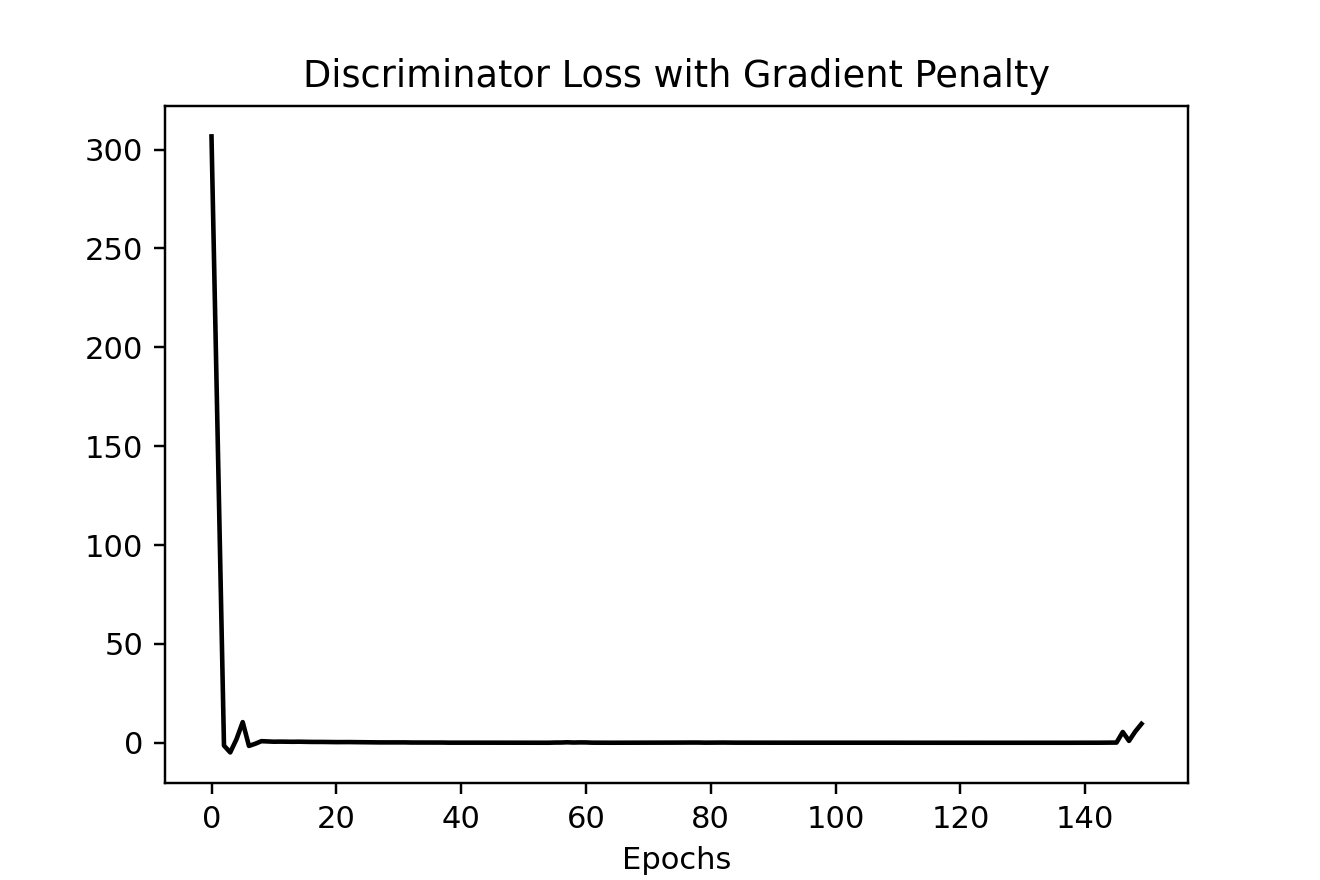

In [22]:
# Visualize Critic loss
plt.figure(figsize = (6, 4))
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('Discriminator Loss with Gradient Penalty')
plt.xlabel('Epochs')

plt.savefig("7day_discLoss.png")

<IPython.core.display.Javascript object>


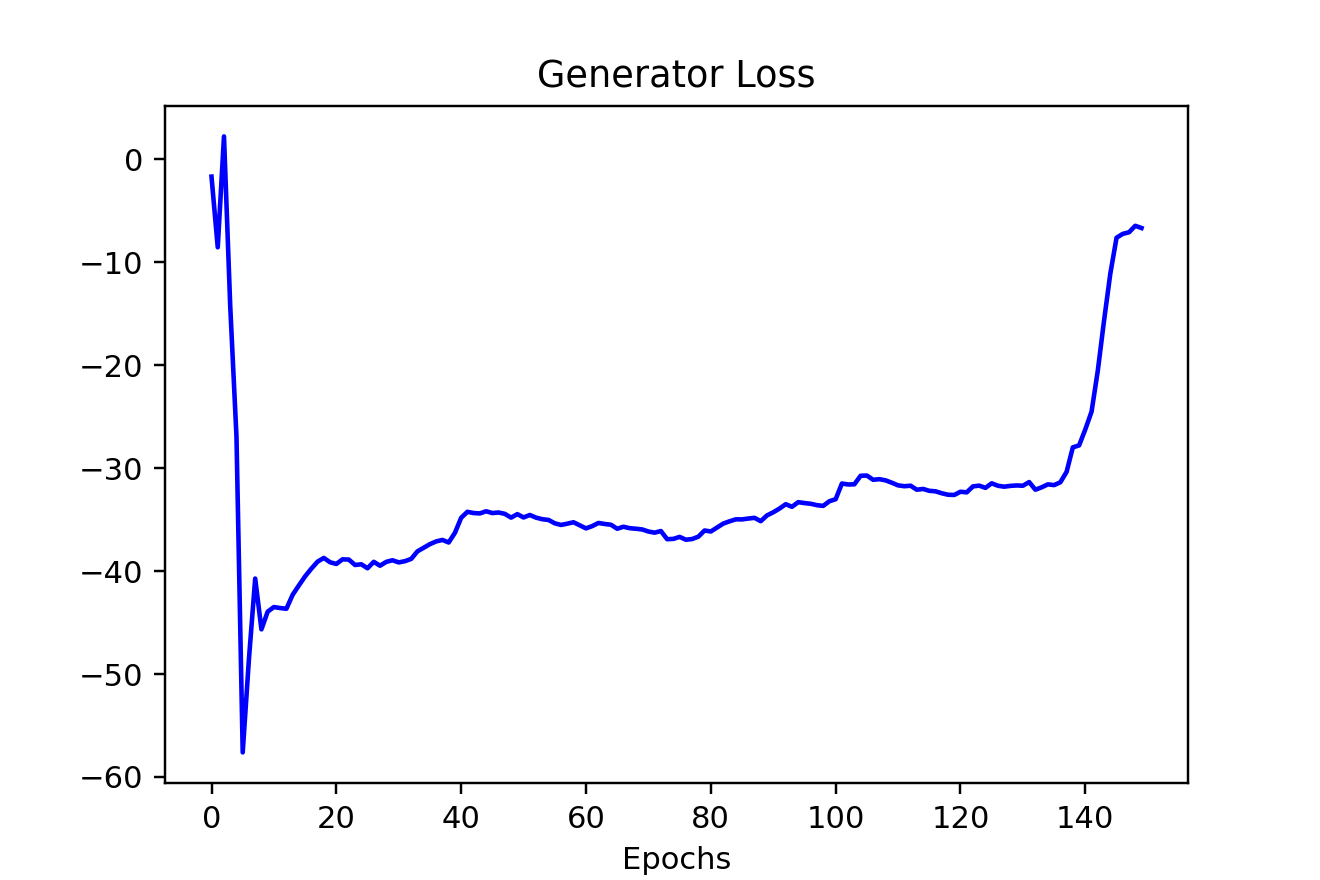

In [23]:
# Visualize Generator Loss
plt.figure(figsize = (6, 4))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.title('Generator Loss')
plt.xlabel('Epochs')

plt.savefig("7day_genLoss.png")

In [24]:
# Make Predictions on training, validation, and testing sets
modelG.eval()

pred_y_train = modelG(train_x_slide)
pred_y_val = modelG(val_x_slide)
pred_y_test = modelG(test_x_slide)

# Define true and predicted values
y_train_true = scaler.inverse_transform(train_y_slide.detach().numpy())
y_train_pred = scaler.inverse_transform(pred_y_train.detach().numpy())

y_val_true = scaler.inverse_transform(val_y_slide.detach().numpy())
y_val_pred = scaler.inverse_transform(pred_y_val.detach().numpy())

y_test_true = scaler.inverse_transform(test_y_slide.detach().numpy())
y_test_pred = scaler.inverse_transform(pred_y_test.detach().numpy())

<IPython.core.display.Javascript object>


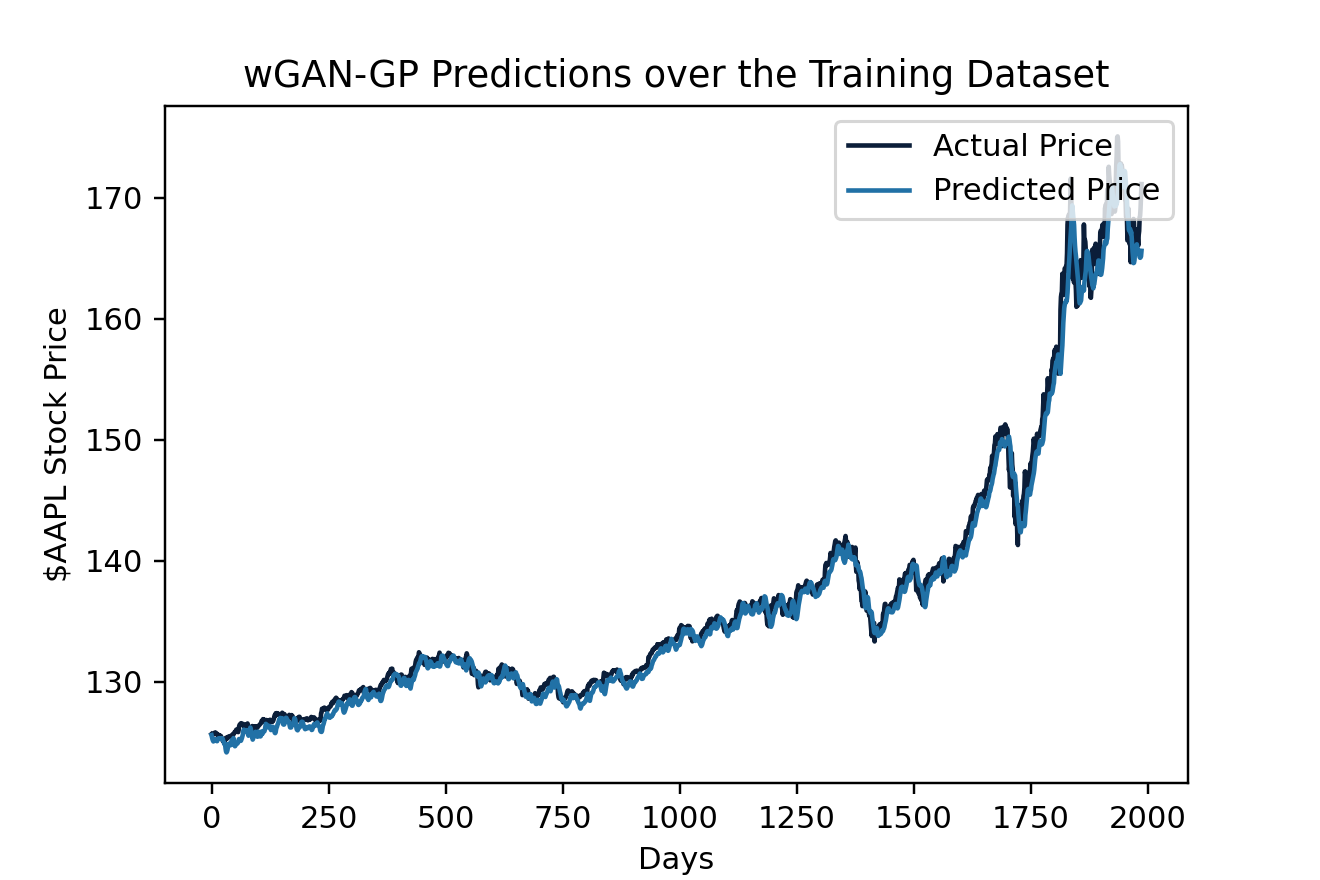

Evaluation Metrics for Training Set
RMSE:1.1430198402485063
NRMSE:0.022842122688567515
MAE:0.8276320099830627
MAPE:0.00582373421639204


In [25]:
# Visualize Predictions on the training set
plt.figure(figsize=(6, 4))
plt.plot(y_train_true, color = '#0B1E39', label = 'Actual Price')
plt.plot(y_train_pred, color = '#2171A6', label = 'Predicted Price')
plt.title('wGAN-GP Predictions over the Training Dataset')
plt.ylabel('$AAPL Stock Price')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

plt.savefig("7day_trainpreds.png")

print('Evaluation Metrics for Training Set')
MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'RMSE:{RMSE}')
NRMSE = RMSE / (np.max(y_train_true) - np.min(y_train_true))
print(f'NRMSE:{NRMSE}')
MAE = mean_absolute_error(y_train_true, y_train_pred)
print(f'MAE:{MAE}')
MAPE = mean_absolute_percentage_error(y_train_true, y_train_pred)
print(f'MAPE:{MAPE}')

<IPython.core.display.Javascript object>


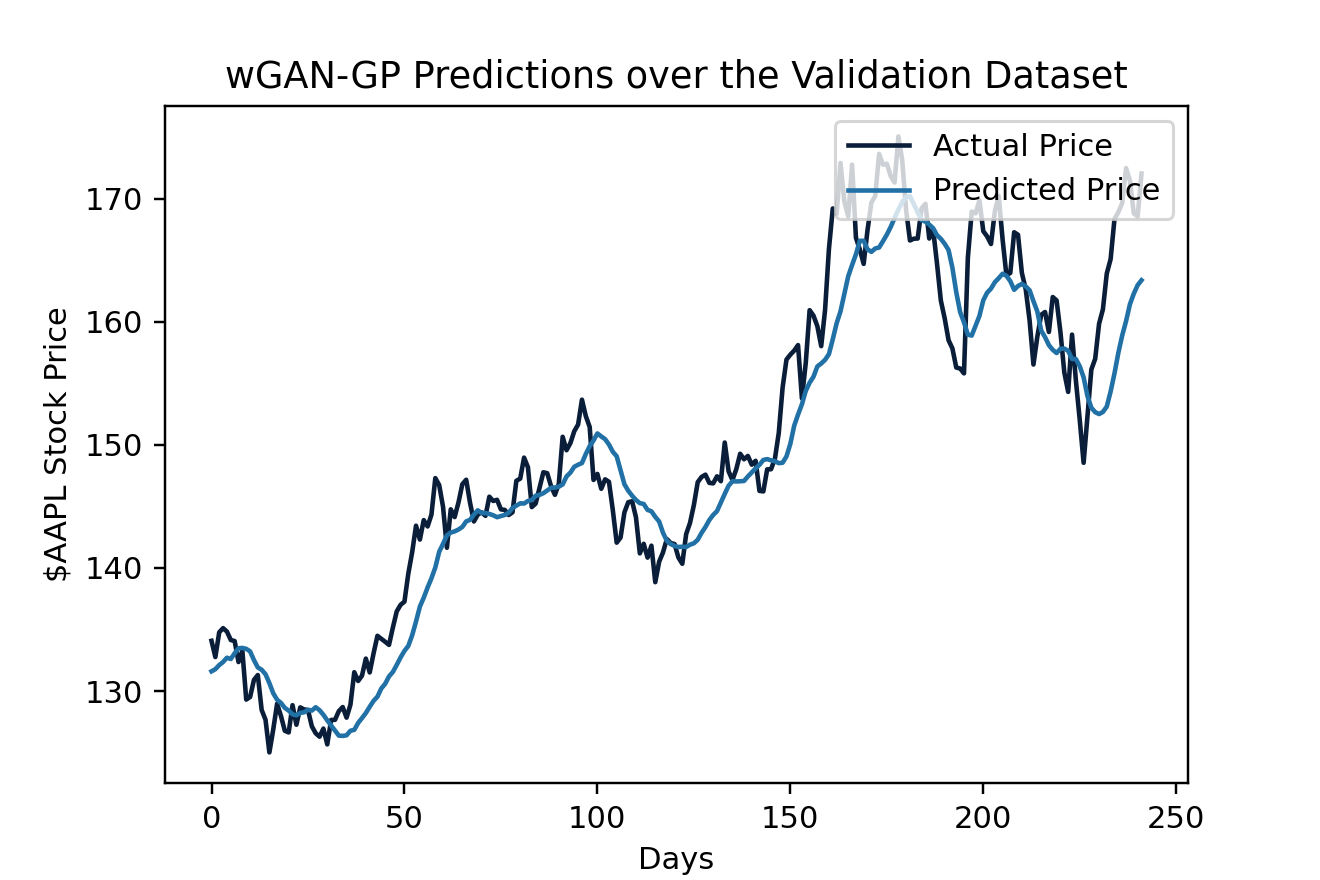

Evaluation Metrics for Validation Set
RMSE:4.3436536160760095
NRMSE:0.08680362782983443
MAE:3.3921151161193848
MAPE:0.02212362177670002


In [26]:
# Visualize Predictions on the validation set
plt.figure(figsize=(6, 4))
plt.plot(y_val_true, color = '#0B1E39', label = 'Actual Price')
plt.plot(y_val_pred, color = '#2171A6', label = 'Predicted Price')
plt.title('wGAN-GP Predictions over the Validation Dataset')
plt.ylabel('$AAPL Stock Price')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

plt.savefig("7day_valpreds.png")

print('Evaluation Metrics for Validation Set')
MSE = mean_squared_error(y_val_true, y_val_pred)
RMSE = math.sqrt(MSE)
print(f'RMSE:{RMSE}')
NRMSE = RMSE / (np.max(y_val_true) - np.min(y_val_true))
print(f'NRMSE:{NRMSE}')
MAE = mean_absolute_error(y_val_true, y_val_pred)
print(f'MAE:{MAE}')
MAPE = mean_absolute_percentage_error(y_val_true, y_val_pred)
print(f'MAPE:{MAPE}')

<IPython.core.display.Javascript object>


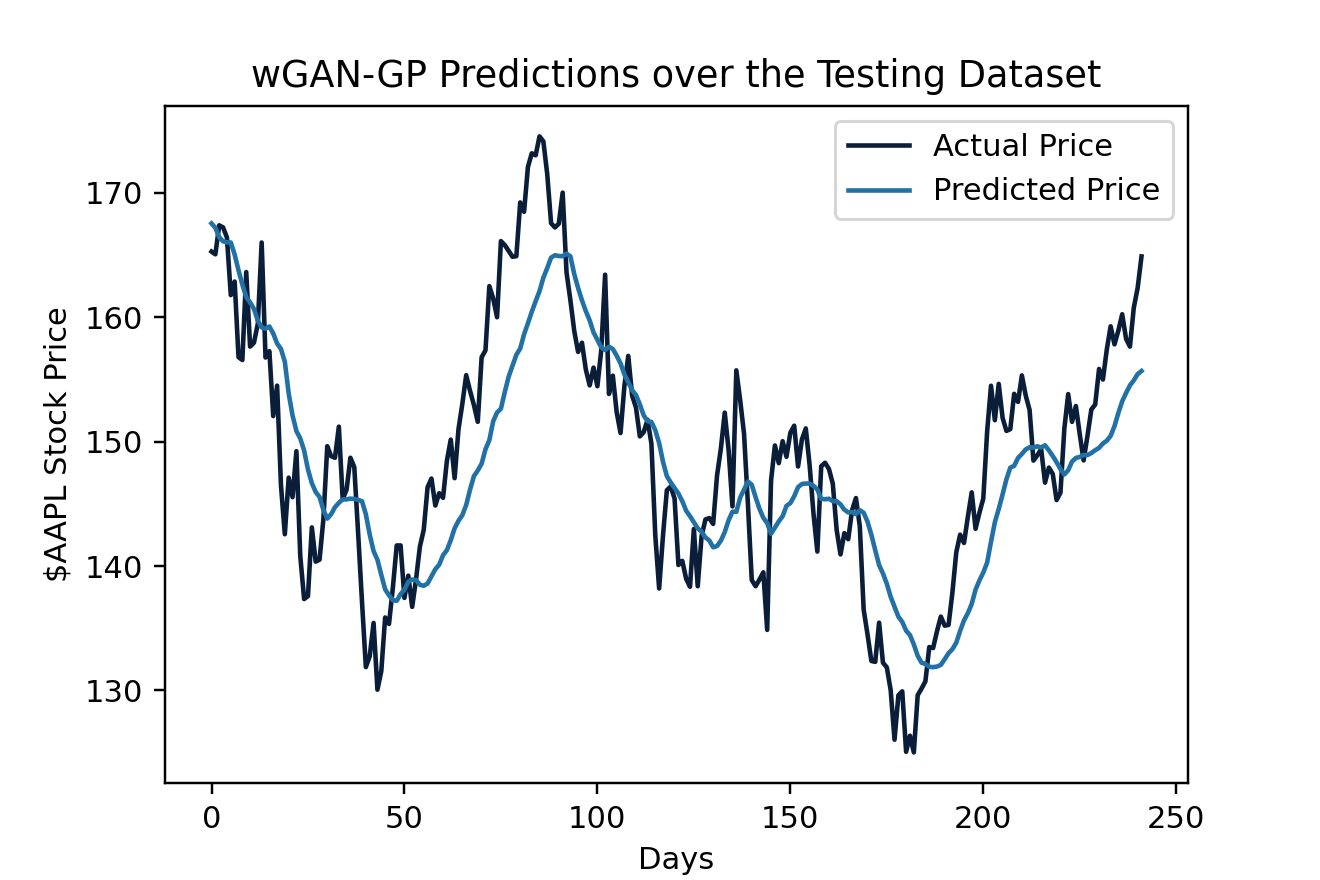

Evaluation Metrics for Test Set
RMSE:6.058618935311934
NRMSE:0.12232219162904816
MAE:5.074516296386719
MAPE:0.034154146909713745


In [27]:
# Visualize Predictions on the test set
plt.figure(figsize=(6, 4))
plt.plot(y_test_true, color = '#0B1E39', label = 'Actual Price')
plt.plot(y_test_pred, color = '#2171A6', label = 'Predicted Price')
plt.title('wGAN-GP Predictions over the Testing Dataset')
plt.ylabel('$AAPL Stock Price')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

plt.savefig("7day_testpreds.png")

print('Evaluation Metrics for Test Set')
MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'RMSE:{RMSE}')
NRMSE = RMSE / (np.max(y_test_true) - np.min(y_test_true))
print(f'NRMSE:{NRMSE}')
MAE = mean_absolute_error(y_test_true, y_test_pred)
print(f'MAE:{MAE}')
MAPE = mean_absolute_percentage_error(y_test_true, y_test_pred)
print(f'MAPE:{MAPE}')

<IPython.core.display.Javascript object>


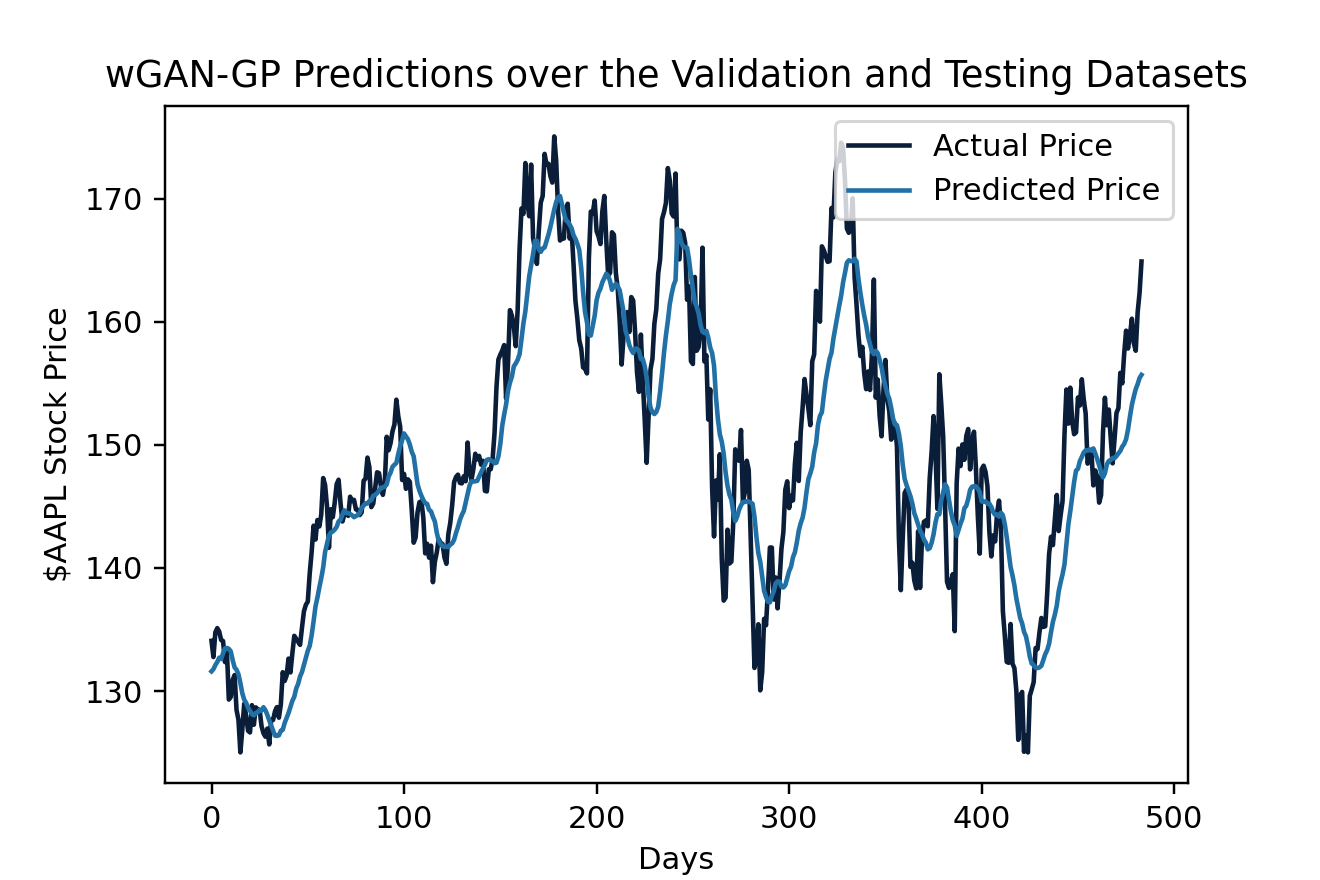

Averaged Evaluation Metrics for Validation and Test Sets
RMSE:5.271346699237261
NRMSE:0.10534265792951994
MAE:4.233315944671631
MAPE:0.028138883411884308


In [28]:
y_true = np.concatenate((y_val_true, y_test_true))
y_pred = np.concatenate((y_val_pred, y_test_pred))

plt.figure(figsize=(6, 4))
plt.plot(y_true, color = '#0B1E39', label = 'Actual Price')
plt.plot(y_pred, color = '#2171A6', label = 'Predicted Price')
plt.title('wGAN-GP Predictions over the Validation and Testing Datasets')
plt.ylabel('$AAPL Stock Price')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

plt.savefig("7day_valandtestpreds.png")

print('Averaged Evaluation Metrics for Validation and Test Sets')
MSE = mean_squared_error(y_true, y_pred)
RMSE = math.sqrt(MSE)
print(f'RMSE:{RMSE}')
NRMSE = RMSE / (np.max(y_true) - np.min(y_true))
print(f'NRMSE:{NRMSE}')
MAE = mean_absolute_error(y_true, y_pred)
print(f'MAE:{MAE}')
MAPE = mean_absolute_percentage_error(y_true, y_pred)
print(f'MAPE:{MAPE}')